# Outlier Investigation

## Purpose
Investigate outliers in cleaned football match data to verify legitimacy and identify potential data quality issues.

## Process Flow
1. **Data Ingestion** → Raw CSV files downloaded
2. **Phase 1 Cleaning** → Critical cleaning (drop columns, convert dates, remove invalid rows)
3. **Phase 2 Enhancement** → Impute missing values, create features, calculate overround
4. **Outlier Investigation** ← **YOU ARE HERE**
5. **Model Training** → Use cleaned data for Dixon-Coles model

## When to Run
- **After Phase 2 Enhancement** (on cleaned data)
- Before model training
- Periodically to monitor data quality


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

# Try to import seaborn (optional)
try:
    import seaborn as sns
    sns.set_style("whitegrid")
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("⚠️  seaborn not installed. Using matplotlib defaults.")
    print("   Install with: pip install seaborn")

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(f"✓ Libraries loaded successfully")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")


✓ Libraries loaded successfully
✓ Pandas version: 2.3.3
✓ NumPy version: 2.3.5


In [16]:
# Find data directory - try multiple paths
possible_paths = [
    # Absolute path (workspace root)
    Path("F:/[ 11 ] Football Probability Engine  [SP Soccer]/2_Backend_Football_Probability_Engine/data/2_Cleaned_data"),
    # Relative from notebook location
    Path("../2_Backend_Football_Probability_Engine/data/2_Cleaned_data"),
    Path("../../2_Backend_Football_Probability_Engine/data/2_Cleaned_data"),
    # Fallback: use ingestion data
    Path("../2_Backend_Football_Probability_Engine/data/1_data_ingestion"),
]

DATA_DIR = None
for path in possible_paths:
    resolved_path = path.resolve()
    if resolved_path.exists() and resolved_path.is_dir():
        DATA_DIR = resolved_path
        break

if DATA_DIR is None:
    DATA_DIR = possible_paths[0].resolve()
    print(f"⚠️  Warning: Could not find data directory automatically")
    print(f"   Using: {DATA_DIR}")
else:
    print(f"✓ Found data directory: {DATA_DIR}")

# List available files
if DATA_DIR.exists():
    csv_files = list(DATA_DIR.glob("*.csv"))
    parquet_files = list(DATA_DIR.glob("*.parquet"))
    print(f"✓ Found {len(csv_files)} CSV files")
    print(f"✓ Found {len(parquet_files)} Parquet files")
    
    if csv_files:
        print(f"\nSample CSV files:")
        for f in csv_files[:5]:
            print(f"  - {f.name}")
else:
    print(f"✗ Data directory not found!")


✓ Found data directory: F:\[ 11 ] Football Probability Engine  [SP Soccer]\2_Backend_Football_Probability_Engine\data\2_Cleaned_data
✓ Found 24 CSV files
✓ Found 24 Parquet files

Sample CSV files:
  - B1_Pro_League_all_seasons.csv
  - D1_Bundesliga_all_seasons.csv
  - D2_2_Bundesliga_all_seasons.csv
  - DK1_Superliga_all_seasons.csv
  - E0_Premier_League_all_seasons.csv


In [17]:
# Load cleaned data
# Prefer Parquet if available (faster), otherwise CSV
dataframes = []

if parquet_files:
    print("Loading Parquet files...")
    for file in parquet_files[:10]:  # Limit to first 10 for performance
        try:
            df = pd.read_parquet(file)
            df['source_file'] = file.name
            dataframes.append(df)
            print(f"  ✓ Loaded {len(df)} rows from {file.name}")
        except Exception as e:
            print(f"  ✗ Error loading {file.name}: {e}")
elif csv_files:
    print("Loading CSV files...")
    for file in csv_files[:10]:  # Limit to first 10 for performance
        try:
            df = pd.read_csv(file)
            df['source_file'] = file.name
            dataframes.append(df)
            print(f"  ✓ Loaded {len(df)} rows from {file.name}")
        except Exception as e:
            print(f"  ✗ Error loading {file.name}: {e}")
else:
    print("⚠️  No cleaned data files found. Loading from ingestion folder...")
    ingestion_dir = Path("../2_Backend_Football_Probability_Engine/data/1_data_ingestion")
    if ingestion_dir.exists():
        batch_folders = list(ingestion_dir.glob("batch_*"))
        for folder in batch_folders[:5]:  # Limit to first 5 batches
            csv_files_batch = list(folder.glob("*.csv"))
            for file in csv_files_batch[:2]:  # Limit to 2 files per batch
                try:
                    df = pd.read_csv(file)
                    df['source_file'] = file.name
                    dataframes.append(df)
                except Exception as e:
                    continue

if not dataframes:
    raise ValueError("No data files found! Please run data preparation first.")

# Combine all dataframes
df = pd.concat(dataframes, ignore_index=True)
print(f"\n✓ Combined dataset: {len(df)} rows × {len(df.columns)} columns")


Loading Parquet files...
  ✓ Loaded 1934 rows from B1_Pro_League_all_seasons.parquet
  ✓ Loaded 1971 rows from D1_Bundesliga_all_seasons.parquet
  ✓ Loaded 1989 rows from D2_2_Bundesliga_all_seasons.parquet
  ✓ Loaded 1971 rows from DK1_Superliga_all_seasons.parquet
  ✓ Loaded 2460 rows from E0_Premier_League_all_seasons.parquet
  ✓ Loaded 3586 rows from E1_Championship_all_seasons.parquet
  ✓ Loaded 3415 rows from E2_League_One_all_seasons.parquet
  ✓ Loaded 3464 rows from E3_League_Two_all_seasons.parquet
  ✓ Loaded 2175 rows from F1_Ligue_1_all_seasons.parquet
  ✓ Loaded 2256 rows from F2_Ligue_2_all_seasons.parquet

✓ Combined dataset: 25221 rows × 18 columns


## 1. Outlier Detection Methods

### Statistical Methods:
- **IQR Method**: Q1 - 1.5×IQR to Q3 + 1.5×IQR
- **Z-Score**: Values with |z| > 3
- **Modified Z-Score**: More robust to outliers

### Domain-Specific Checks:
- Goals: Typically 0-10 per match
- Odds: Typically 1.01 - 100.0
- Overround: Typically 0.02 - 0.15 (2-15%)
- TotalGoals: Typically 0-10
- GoalDifference: Typically -10 to +10


In [18]:
# Identify numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Key columns to check
key_columns = [
    'FTHG', 'FTAG', 'TotalGoals', 'GoalDifference',
    'AvgH', 'AvgD', 'AvgA', 'Overround',
    'prob_home_market', 'prob_draw_market', 'prob_away_market'
]

# Filter to columns that exist
outlier_cols = [col for col in key_columns if col in df.columns]
outlier_cols.extend([col for col in numeric_cols if col not in outlier_cols and col not in ['Year', 'Month', 'DayOfWeek']])

print(f"Columns to check for outliers: {len(outlier_cols)}")
print(f"\nKey columns: {outlier_cols[:10]}")


Columns to check for outliers: 12

Key columns: ['FTHG', 'FTAG', 'AvgH', 'AvgD', 'AvgA', 'prob_home_market', 'prob_draw_market', 'prob_away_market', 'season', 'league_id']


In [19]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(series, multiplier=1.5):
    """Detect outliers using Interquartile Range method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers, lower_bound, upper_bound

# Function to detect outliers using Z-score
def detect_outliers_zscore(series, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs((series - series.mean()) / series.std())
    outliers = z_scores > threshold
    return outliers

# Function to detect outliers using Modified Z-score (more robust)
def detect_outliers_modified_zscore(series, threshold=3.5):
    """Detect outliers using Modified Z-score (median-based)"""
    median = series.median()
    mad = (series - median).abs().median()  # Median Absolute Deviation
    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)
    modified_z_scores = 0.6745 * (series - median) / mad
    outliers = np.abs(modified_z_scores) > threshold
    return outliers

print("✓ Outlier detection functions defined")


✓ Outlier detection functions defined


In [20]:
# Detect outliers for each column
outlier_results = {}

for col in outlier_cols:
    if col not in df.columns:
        continue
    
    series = df[col].dropna()
    if len(series) == 0:
        continue
    
    # IQR method
    outliers_iqr, lower, upper = detect_outliers_iqr(series)
    
    # Z-score method
    outliers_zscore = detect_outliers_zscore(series)
    
    # Modified Z-score
    outliers_mod_zscore = detect_outliers_modified_zscore(series)
    
    outlier_results[col] = {
        'total_values': len(series),
        'missing': df[col].isna().sum(),
        'mean': series.mean(),
        'median': series.median(),
        'std': series.std(),
        'min': series.min(),
        'max': series.max(),
        'outliers_iqr': outliers_iqr.sum(),
        'outliers_zscore': outliers_zscore.sum(),
        'outliers_mod_zscore': outliers_mod_zscore.sum(),
        'lower_bound': lower,
        'upper_bound': upper,
        'outlier_indices': series[outliers_iqr].index.tolist()[:20]  # First 20 outliers
    }

print(f"✓ Analyzed {len(outlier_results)} columns for outliers")


✓ Analyzed 12 columns for outliers


## 2. Outlier Summary Report


In [21]:
# Create summary DataFrame
summary_data = []
for col, stats in outlier_results.items():
    summary_data.append({
        'Column': col,
        'Total': stats['total_values'],
        'Missing': stats['missing'],
        'Mean': stats['mean'],
        'Median': stats['median'],
        'Min': stats['min'],
        'Max': stats['max'],
        'Outliers (IQR)': stats['outliers_iqr'],
        'Outliers (%)': (stats['outliers_iqr'] / stats['total_values'] * 100) if stats['total_values'] > 0 else 0,
        'Outliers (Z-score)': stats['outliers_zscore'],
        'Outliers (Mod Z)': stats['outliers_mod_zscore'],
        'Lower Bound': stats['lower_bound'],
        'Upper Bound': stats['upper_bound']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Outliers (IQR)', ascending=False)

print("\n" + "="*100)
print("OUTLIER SUMMARY REPORT")
print("="*100)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('outlier_summary.csv', index=False)
print("\n✓ Saved outlier_summary.csv")



OUTLIER SUMMARY REPORT
          Column  Total  Missing        Mean      Median         Min         Max  Outliers (IQR)  Outliers (%)  Outliers (Z-score)  Outliers (Mod Z)  Lower Bound  Upper Bound
            AvgD  25215        6    3.783032    3.520000    2.090000   16.440000            2274      9.018441                 535              2050     2.495000     4.695000
            FTHG  25221        0    1.500734    1.000000    0.000000    9.000000            1811      7.180524                 178                53    -0.500000     3.500000
            AvgA  25215        6    3.790790    3.140000    1.080000   38.040000            1722      6.829268                 478              1464    -0.260000     6.940000
prob_draw_market  25215        6    0.258986    0.268066    0.058516    0.455636            1535      6.087646                 502              1085     0.185318     0.343613
            AvgH  25215        6    2.573442    2.260000    1.050000   34.140000            1511     

## 3. Domain-Specific Validation

Check if outliers are legitimate or data errors


In [22]:
# Domain-specific checks
domain_issues = []

# Goals check
if 'FTHG' in df.columns:
    invalid_goals = (df['FTHG'] < 0) | (df['FTHG'] > 15)
    if invalid_goals.sum() > 0:
        domain_issues.append({
            'Column': 'FTHG',
            'Issue': 'Goals outside valid range (0-15)',
            'Count': invalid_goals.sum(),
            'Examples': df[invalid_goals][['FTHG', 'FTAG']].head(5).to_dict('records') if 'FTAG' in df.columns else []
        })

if 'FTAG' in df.columns:
    invalid_goals = (df['FTAG'] < 0) | (df['FTAG'] > 15)
    if invalid_goals.sum() > 0:
        domain_issues.append({
            'Column': 'FTAG',
            'Issue': 'Goals outside valid range (0-15)',
            'Count': invalid_goals.sum(),
            'Examples': df[invalid_goals][['FTHG', 'FTAG']].head(5).to_dict('records') if 'FTHG' in df.columns else []
        })

# Odds check
for odds_col in ['AvgH', 'AvgD', 'AvgA']:
    if odds_col in df.columns:
        invalid_odds = (df[odds_col] < 1.01) | (df[odds_col] > 100.0)
        if invalid_odds.sum() > 0:
            domain_issues.append({
                'Column': odds_col,
                'Issue': 'Odds outside valid range (1.01-100.0)',
                'Count': invalid_odds.sum(),
                'Examples': df[invalid_odds][odds_col].head(5).tolist()
            })

# Overround check
if 'Overround' in df.columns:
    invalid_overround = (df['Overround'] < -0.1) | (df['Overround'] > 0.5)
    if invalid_overround.sum() > 0:
        domain_issues.append({
            'Column': 'Overround',
            'Issue': 'Overround outside expected range (-0.1 to 0.5)',
            'Count': invalid_overround.sum(),
            'Examples': df[invalid_overround]['Overround'].head(5).tolist()
        })

print(f"\n✓ Found {len(domain_issues)} domain-specific issues")
for issue in domain_issues:
    print(f"\n  {issue['Column']}: {issue['Issue']} ({issue['Count']} cases)")



✓ Found 0 domain-specific issues


## 4. Visualizations


✓ Saved outlier_distributions.png


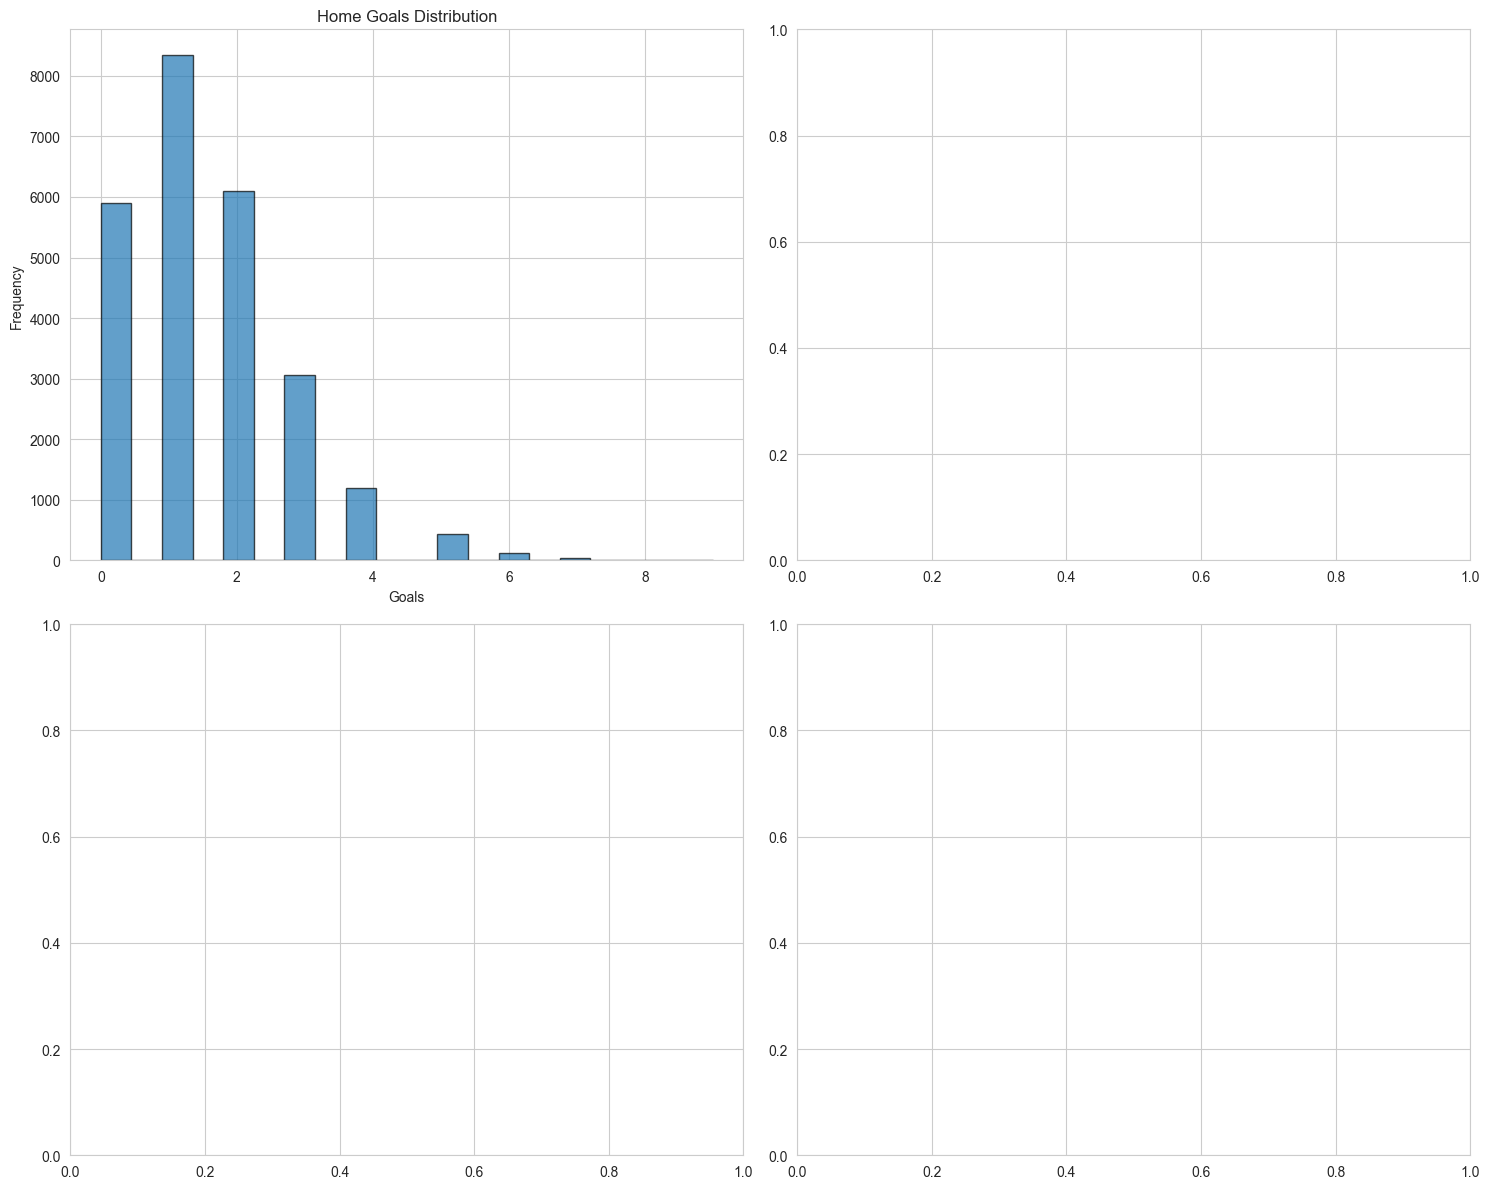

In [23]:
# Create visualizations for key columns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0

# Goals distribution
if 'FTHG' in df.columns:
    axes[plot_idx].hist(df['FTHG'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[plot_idx].set_title('Home Goals Distribution')
    axes[plot_idx].set_xlabel('Goals')
    axes[plot_idx].set_ylabel('Frequency')
    plot_idx += 1

# Total Goals
if 'TotalGoals' in df.columns:
    axes[plot_idx].hist(df['TotalGoals'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[plot_idx].set_title('Total Goals Distribution')
    axes[plot_idx].set_xlabel('Total Goals')
    axes[plot_idx].set_ylabel('Frequency')
    plot_idx += 1

# Overround
if 'Overround' in df.columns:
    axes[plot_idx].hist(df['Overround'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[plot_idx].set_title('Overround Distribution')
    axes[plot_idx].set_xlabel('Overround')
    axes[plot_idx].set_ylabel('Frequency')
    plot_idx += 1

# Goal Difference
if 'GoalDifference' in df.columns:
    axes[plot_idx].hist(df['GoalDifference'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[plot_idx].set_title('Goal Difference Distribution')
    axes[plot_idx].set_xlabel('Goal Difference')
    axes[plot_idx].set_ylabel('Frequency')
    plot_idx += 1

plt.tight_layout()
plt.savefig('outlier_distributions.png', dpi=150, bbox_inches='tight')
print("✓ Saved outlier_distributions.png")
plt.show()


## 5. Recommendations

Based on outlier analysis, provide recommendations for data cleaning


In [24]:
# Generate recommendations
recommendations = []

# Check each column
for col, stats in outlier_results.items():
    outlier_pct = (stats['outliers_iqr'] / stats['total_values'] * 100) if stats['total_values'] > 0 else 0
    
    if outlier_pct > 5:  # More than 5% outliers
        recommendations.append({
            'Column': col,
            'Outlier %': f"{outlier_pct:.2f}%",
            'Recommendation': 'Investigate - high outlier rate',
            'Action': 'Review data source and verify legitimacy'
        })
    elif outlier_pct > 1:  # 1-5% outliers
        recommendations.append({
            'Column': col,
            'Outlier %': f"{outlier_pct:.2f}%",
            'Recommendation': 'Monitor - moderate outlier rate',
            'Action': 'Verify outliers are legitimate (e.g., high-scoring matches)'
        })

# Add domain-specific recommendations
for issue in domain_issues:
    recommendations.append({
        'Column': issue['Column'],
        'Outlier %': 'N/A',
        'Recommendation': 'CRITICAL - Data validation failure',
        'Action': f"Remove or correct {issue['Count']} invalid values"
    })

if recommendations:
    rec_df = pd.DataFrame(recommendations)
    print("\n" + "="*100)
    print("RECOMMENDATIONS")
    print("="*100)
    print(rec_df.to_string(index=False))
    rec_df.to_csv('outlier_recommendations.csv', index=False)
    print("\n✓ Saved outlier_recommendations.csv")
else:
    print("\n✓ No significant outlier issues found. Data quality is good!")



RECOMMENDATIONS
          Column Outlier %                  Recommendation                                                      Action
            FTHG     7.18% Investigate - high outlier rate                    Review data source and verify legitimacy
            AvgH     5.99% Investigate - high outlier rate                    Review data source and verify legitimacy
            AvgD     9.02% Investigate - high outlier rate                    Review data source and verify legitimacy
            AvgA     6.83% Investigate - high outlier rate                    Review data source and verify legitimacy
prob_home_market     1.20% Monitor - moderate outlier rate Verify outliers are legitimate (e.g., high-scoring matches)
prob_draw_market     6.09% Investigate - high outlier rate                    Review data source and verify legitimacy
prob_away_market     2.32% Monitor - moderate outlier rate Verify outliers are legitimate (e.g., high-scoring matches)

✓ Saved outlier_recommendation

## 6. Export Report


In [25]:
# Create comprehensive report
report = {
    'timestamp': datetime.now().isoformat(),
    'total_rows': len(df),
    'total_columns': len(df.columns),
    'columns_analyzed': len(outlier_results),
    'outlier_summary': summary_df.to_dict('records'),
    'domain_issues': domain_issues,
    'recommendations': recommendations if 'recommendations' in locals() else [],
    'data_quality_score': {
        'overall': 100 - min(100, sum([r['Outliers (%)'] for r in summary_df.to_dict('records')]) / len(summary_df) * 10) if len(summary_df) > 0 else 100,
        'outlier_rate': sum([stats['outliers_iqr'] for stats in outlier_results.values()]) / sum([stats['total_values'] for stats in outlier_results.values()]) * 100 if sum([stats['total_values'] for stats in outlier_results.values()]) > 0 else 0
    }
}

# Save report
report_filename = f"outlier_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(report_filename, 'w') as f:
    json.dump(report, f, indent=2, default=str)

print(f"\n✓ Saved comprehensive report: {report_filename}")
print(f"\nData Quality Score: {report['data_quality_score']['overall']:.2f}/100")
print(f"Overall Outlier Rate: {report['data_quality_score']['outlier_rate']:.2f}%")



✓ Saved comprehensive report: outlier_report_20251229_091747.json

Data Quality Score: 67.54/100
Overall Outlier Rate: 3.25%


## 7. Manual Review & Data Validation

Sample extreme outliers for manual review and validate against source data.


In [27]:
# Manual Review: Sample Extreme Outliers
# This cell samples extreme outliers from high-outlier columns for manual review

import pandas as pd
from datetime import datetime

# Configuration
SAMPLE_SIZE = 50  # Number of outliers to sample per column
HIGH_OUTLIER_COLUMNS = ['AvgD', 'FTHG', 'AvgA', 'prob_draw_market', 'AvgH']

def sample_extreme_outliers(df, column, outlier_results, sample_size=SAMPLE_SIZE):
    """
    Sample extreme outliers from a column for manual review
    
    Args:
        df: DataFrame with data
        column: Column name to analyze
        outlier_results: Dictionary with outlier statistics
        sample_size: Number of outliers to sample
        
    Returns:
        DataFrame with sampled outliers and context
    """
    if column not in outlier_results:
        return pd.DataFrame()
    
    # Handle duplicate column names by keeping only the first occurrence
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()]
    
    stats = outlier_results[column]
    upper_bound = stats['upper_bound']
    lower_bound = stats['lower_bound']
    
    # Get outliers (values outside IQR bounds)
    if column in df.columns:
        outliers_upper = df[df[column] > upper_bound].copy()
        outliers_lower = df[df[column] < lower_bound].copy()
        
        # Sample from upper outliers (usually more interesting)
        if len(outliers_upper) > 0:
            sampled_upper = outliers_upper.nlargest(min(sample_size, len(outliers_upper)), column)
            sampled_upper['outlier_type'] = 'upper'
            sampled_upper['bound'] = upper_bound
            sampled_upper['deviation'] = sampled_upper[column] - upper_bound
        else:
            sampled_upper = pd.DataFrame()
        
        # Sample from lower outliers if significant
        if len(outliers_lower) > 0 and lower_bound > 0:  # Only if lower bound makes sense
            sampled_lower = outliers_lower.nsmallest(min(10, len(outliers_lower)), column)
            sampled_lower['outlier_type'] = 'lower'
            sampled_lower['bound'] = lower_bound
            sampled_lower['deviation'] = sampled_lower[column] - lower_bound
        else:
            sampled_lower = pd.DataFrame()
        
        # Combine and add context columns
        if not sampled_upper.empty or not sampled_lower.empty:
            sampled = pd.concat([sampled_upper, sampled_lower], ignore_index=True)
            
            # Handle duplicate columns in sampled DataFrame
            if sampled.columns.duplicated().any():
                sampled = sampled.loc[:, ~sampled.columns.duplicated()]
            
            # Add context columns for review
            context_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'season', 'league_id']
            available_cols = [col for col in context_cols if col in sampled.columns]
            
            # Select relevant columns for review (ensure no duplicates)
            review_cols = available_cols + [column, 'outlier_type', 'bound', 'deviation']
            review_cols = [col for col in review_cols if col in sampled.columns]
            # Remove duplicates while preserving order
            seen = set()
            review_cols_unique = []
            for col in review_cols:
                if col not in seen:
                    seen.add(col)
                    review_cols_unique.append(col)
            
            # Ensure the column we're sorting by exists and is unique
            if column in sampled.columns:
                return sampled[review_cols_unique].sort_values(column, ascending=False)
            else:
                return sampled[review_cols_unique]
    
    return pd.DataFrame()

# Check for duplicate columns in the dataframe
if df.columns.duplicated().any():
    print("⚠️  Warning: Found duplicate column names in dataframe")
    print(f"   Duplicate columns: {df.columns[df.columns.duplicated()].tolist()}")
    print("   Removing duplicates (keeping first occurrence)...")
    df = df.loc[:, ~df.columns.duplicated()]
    print("   ✓ Duplicate columns removed\n")

# Sample outliers for each high-outlier column
print("="*100)
print("SAMPLING EXTREME OUTLIERS FOR MANUAL REVIEW")
print("="*100)
print(f"\nSample size: {SAMPLE_SIZE} outliers per column")
print(f"Columns to review: {', '.join(HIGH_OUTLIER_COLUMNS)}\n")

sampled_outliers = {}

for column in HIGH_OUTLIER_COLUMNS:
    if column in outlier_results:
        print(f"\n{'='*100}")
        print(f"Column: {column}")
        print(f"{'='*100}")
        
        sampled = sample_extreme_outliers(df, column, outlier_results, SAMPLE_SIZE)
        
        if not sampled.empty:
            sampled_outliers[column] = sampled
            
            stats = outlier_results[column]
            print(f"\nStatistics:")
            print(f"  Mean: {stats['mean']:.4f}")
            print(f"  Median: {stats['median']:.4f}")
            print(f"  Upper Bound (IQR): {stats['upper_bound']:.4f}")
            print(f"  Lower Bound (IQR): {stats['lower_bound']:.4f}")
            print(f"  Total Outliers: {stats['outliers_iqr']}")
            print(f"  Outlier Rate: {stats['outliers_iqr'] / stats['total_values'] * 100:.2f}%")
            
            print(f"\nSampled {len(sampled)} outliers:")
            print(sampled.head(20).to_string(index=False))
            
            if len(sampled) > 20:
                print(f"\n... and {len(sampled) - 20} more outliers")
        else:
            print(f"  ⚠️  No outliers found or column not in dataframe")
    else:
        print(f"\n⚠️  Column '{column}' not found in outlier_results")

print(f"\n{'='*100}")
print("SAMPLING COMPLETE")
print(f"{'='*100}")


SAMPLING EXTREME OUTLIERS FOR MANUAL REVIEW

Sample size: 50 outliers per column
Columns to review: AvgD, FTHG, AvgA, prob_draw_market, AvgH


Column: AvgD

Statistics:
  Mean: 3.7830
  Median: 3.5200
  Upper Bound (IQR): 4.6950
  Lower Bound (IQR): 2.4950
  Total Outliers: 2274
  Outlier Rate: 9.02%

Sampled 51 outliers:
      Date      HomeTeam         AwayTeam  FTHG  FTAG  season  league_id  AvgD outlier_type  bound  deviation
2025-02-01 Bayern Munich    Holstein Kiel     4     3    2425          3 16.44        upper  4.695     11.745
2025-02-01 Bayern Munich    Holstein Kiel     4     3    2425         34 16.44        upper  4.695     11.745
2023-11-11 Bayern Munich       Heidenheim     4     2    2324          3 15.98        upper  4.695     11.285
2023-11-11 Bayern Munich       Heidenheim     4     2    2324         34 15.98        upper  4.695     11.285
2020-10-24      Paris FC            Dijon     4     0    2021          5 15.05        upper  4.695     10.355
2023-10-28 Bayer

In [28]:
# Export Sampled Outliers for Manual Review
# Save to CSV files for easy review in Excel or other tools

if sampled_outliers:
    print("Exporting sampled outliers to CSV files...\n")
    
    for column, sampled_df in sampled_outliers.items():
        if not sampled_df.empty:
            filename = f"outlier_samples_{column}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            sampled_df.to_csv(filename, index=False)
            print(f"✓ Saved {len(sampled_df)} outliers for {column}: {filename}")
    
    # Create combined summary file
    summary_rows = []
    for column, sampled_df in sampled_outliers.items():
        if not sampled_df.empty:
            summary_rows.append({
                'Column': column,
                'Total_Sampled': len(sampled_df),
                'Upper_Outliers': len(sampled_df[sampled_df['outlier_type'] == 'upper']),
                'Lower_Outliers': len(sampled_df[sampled_df['outlier_type'] == 'lower']),
                'Max_Value': sampled_df[column].max(),
                'Min_Value': sampled_df[column].min(),
                'Mean_Deviation': sampled_df['deviation'].abs().mean() if 'deviation' in sampled_df.columns else None
            })
    
    if summary_rows:
        summary_df = pd.DataFrame(summary_rows)
        summary_filename = f"outlier_samples_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        summary_df.to_csv(summary_filename, index=False)
        print(f"\n✓ Saved summary: {summary_filename}")
        print(f"\nSummary:")
        print(summary_df.to_string(index=False))
else:
    print("⚠️  No outliers sampled. Run the previous cell first.")


Exporting sampled outliers to CSV files...

✓ Saved 51 outliers for AvgD: outlier_samples_AvgD_20251229_093403.csv
✓ Saved 50 outliers for FTHG: outlier_samples_FTHG_20251229_093403.csv
✓ Saved 50 outliers for AvgA: outlier_samples_AvgA_20251229_093403.csv
✓ Saved 13 outliers for prob_draw_market: outlier_samples_prob_draw_market_20251229_093403.csv
✓ Saved 50 outliers for AvgH: outlier_samples_AvgH_20251229_093403.csv

✓ Saved summary: outlier_samples_summary_20251229_093403.csv

Summary:
          Column  Total_Sampled  Upper_Outliers  Lower_Outliers  Max_Value  Min_Value  Mean_Deviation
            AvgD             51              50               1  16.440000   2.090000        7.975784
            FTHG             50              50               0   9.000000   7.000000        3.880000
            AvgA             50              50               0  38.040000  24.690000       21.591800
prob_draw_market             13               3              10   0.455636   0.058516        0.10

In [29]:
# Data Validation: Check Source Data Quality
# Validate outliers against expected patterns and check for data errors

def validate_outlier_data(df, column, outlier_results, validation_rules=None):
    """
    Validate outlier data against expected patterns
    
    Args:
        df: DataFrame with data
        column: Column name to validate
        outlier_results: Dictionary with outlier statistics
        validation_rules: Dictionary with validation rules
        
    Returns:
        Dictionary with validation results
    """
    if column not in outlier_results or column not in df.columns:
        return {'status': 'skipped', 'reason': 'Column not found'}
    
    stats = outlier_results[column]
    upper_bound = stats['upper_bound']
    lower_bound = stats['lower_bound']
    
    outliers = df[(df[column] > upper_bound) | (df[column] < lower_bound)].copy()
    
    validation_results = {
        'column': column,
        'total_outliers': len(outliers),
        'upper_bound': upper_bound,
        'lower_bound': lower_bound,
        'issues': [],
        'warnings': [],
        'checks_passed': []
    }
    
    # Validation Rule 1: Check for impossible values
    if column in ['FTHG', 'FTAG']:
        # Goals should be non-negative integers
        invalid_goals = outliers[(outliers[column] < 0) | (outliers[column] != outliers[column].astype(int))]
        if len(invalid_goals) > 0:
            validation_results['issues'].append(f"Found {len(invalid_goals)} invalid goal values (negative or non-integer)")
        
        # Goals > 10 are extremely rare (likely data errors)
        extreme_goals = outliers[outliers[column] > 10]
        if len(extreme_goals) > 0:
            validation_results['warnings'].append(f"Found {len(extreme_goals)} matches with >10 goals (extremely rare, verify)")
        
        validation_results['checks_passed'].append("Goal values are non-negative integers")
    
    # Validation Rule 2: Check for probability bounds
    if 'prob' in column.lower() or column.startswith('prob_'):
        # Probabilities should be between 0 and 1
        invalid_probs = outliers[(outliers[column] < 0) | (outliers[column] > 1)]
        if len(invalid_probs) > 0:
            validation_results['issues'].append(f"Found {len(invalid_probs)} invalid probability values (outside 0-1 range)")
        
        validation_results['checks_passed'].append("Probabilities are within 0-1 range")
    
    # Validation Rule 3: Check for odds bounds
    if column.startswith('Avg') and column in ['AvgH', 'AvgA', 'AvgD']:
        # Odds should be positive and typically between 1.01 and 50
        invalid_odds = outliers[outliers[column] <= 0]
        if len(invalid_odds) > 0:
            validation_results['issues'].append(f"Found {len(invalid_odds)} invalid odds values (non-positive)")
        
        # Odds > 50 are extremely rare (likely data errors)
        extreme_odds = outliers[outliers[column] > 50]
        if len(extreme_odds) > 0:
            validation_results['warnings'].append(f"Found {len(extreme_odds)} matches with odds >50 (extremely rare, verify)")
        
        validation_results['checks_passed'].append("Odds values are positive")
    
    # Validation Rule 4: Check for data entry errors (common patterns)
    # Check for values that look like decimal point errors (e.g., 99 instead of 9.9)
    if column in ['AvgH', 'AvgA', 'AvgD']:
        # Check for values > 100 (likely decimal point error)
        decimal_errors = outliers[outliers[column] > 100]
        if len(decimal_errors) > 0:
            validation_results['issues'].append(f"Found {len(decimal_errors)} potential decimal point errors (values >100)")
    
    # Validation Rule 5: Check for missing context data
    context_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
    missing_context = outliers[context_cols].isnull().any(axis=1).sum()
    if missing_context > 0:
        validation_results['warnings'].append(f"Found {missing_context} outliers with missing context data")
    
    # Determine overall status
    if len(validation_results['issues']) > 0:
        validation_results['status'] = 'failed'
    elif len(validation_results['warnings']) > 0:
        validation_results['status'] = 'warning'
    else:
        validation_results['status'] = 'passed'
    
    return validation_results

# Run validation for high-outlier columns
print("="*100)
print("DATA VALIDATION: CHECKING SOURCE DATA QUALITY")
print("="*100)
print()

validation_results = {}

for column in HIGH_OUTLIER_COLUMNS:
    if column in outlier_results:
        print(f"\n{'='*80}")
        print(f"Validating: {column}")
        print(f"{'='*80}")
        
        result = validate_outlier_data(df, column, outlier_results)
        validation_results[column] = result
        
        print(f"\nStatus: {result['status'].upper()}")
        print(f"Total Outliers: {result['total_outliers']}")
        print(f"Upper Bound: {result['upper_bound']:.4f}")
        print(f"Lower Bound: {result['lower_bound']:.4f}")
        
        if result['checks_passed']:
            print(f"\n✓ Checks Passed:")
            for check in result['checks_passed']:
                print(f"  • {check}")
        
        if result['warnings']:
            print(f"\n⚠️  Warnings:")
            for warning in result['warnings']:
                print(f"  • {warning}")
        
        if result['issues']:
            print(f"\n❌ Issues Found:")
            for issue in result['issues']:
                print(f"  • {issue}")
        
        if result['status'] == 'passed':
            print(f"\n✅ Validation PASSED - No issues found")
        elif result['status'] == 'warning':
            print(f"\n⚠️  Validation WARNING - Review recommended")
        else:
            print(f"\n❌ Validation FAILED - Action required")

print(f"\n{'='*100}")
print("VALIDATION COMPLETE")
print(f"{'='*100}")


DATA VALIDATION: CHECKING SOURCE DATA QUALITY


Validating: AvgD

Status: PASSED
Total Outliers: 2274
Upper Bound: 4.6950
Lower Bound: 2.4950

✓ Checks Passed:
  • Odds values are positive

✅ Validation PASSED - No issues found

Validating: FTHG

Status: PASSED
Total Outliers: 1811
Upper Bound: 3.5000
Lower Bound: -0.5000

✓ Checks Passed:
  • Goal values are non-negative integers

✅ Validation PASSED - No issues found

Validating: AvgA

Status: PASSED
Total Outliers: 1722
Upper Bound: 6.9400
Lower Bound: -0.2600

✓ Checks Passed:
  • Odds values are positive

✅ Validation PASSED - No issues found

Validating: prob_draw_market

Status: PASSED
Total Outliers: 1535
Upper Bound: 0.3436
Lower Bound: 0.1853

✓ Checks Passed:
  • Probabilities are within 0-1 range

✅ Validation PASSED - No issues found

Validating: AvgH

Status: PASSED
Total Outliers: 1511
Upper Bound: 4.4450
Lower Bound: 0.2450

✓ Checks Passed:
  • Odds values are positive

✅ Validation PASSED - No issues found

VALIDATION

In [30]:
# Export Validation Report
# Save validation results to JSON and CSV for documentation

if validation_results:
    # Create validation summary
    validation_summary = {
        'timestamp': datetime.now().isoformat(),
        'total_columns_validated': len(validation_results),
        'columns_passed': sum(1 for r in validation_results.values() if r['status'] == 'passed'),
        'columns_warning': sum(1 for r in validation_results.values() if r['status'] == 'warning'),
        'columns_failed': sum(1 for r in validation_results.values() if r['status'] == 'failed'),
        'validation_details': validation_results
    }
    
    # Save to JSON
    validation_filename = f"outlier_validation_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(validation_filename, 'w') as f:
        import json
        json.dump(validation_summary, f, indent=2, default=str)
    print(f"✓ Saved validation report: {validation_filename}")
    
    # Create summary DataFrame
    summary_data = []
    for column, result in validation_results.items():
        summary_data.append({
            'Column': column,
            'Status': result['status'],
            'Total_Outliers': result['total_outliers'],
            'Issues': len(result['issues']),
            'Warnings': len(result['warnings']),
            'Checks_Passed': len(result['checks_passed']),
            'Issues_List': '; '.join(result['issues']) if result['issues'] else 'None',
            'Warnings_List': '; '.join(result['warnings']) if result['warnings'] else 'None'
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_filename = f"outlier_validation_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"✓ Saved validation summary: {summary_filename}")
    
    print(f"\n{'='*100}")
    print("VALIDATION SUMMARY")
    print(f"{'='*100}")
    print(f"\nTotal Columns Validated: {validation_summary['total_columns_validated']}")
    print(f"✓ Passed: {validation_summary['columns_passed']}")
    print(f"⚠️  Warning: {validation_summary['columns_warning']}")
    print(f"❌ Failed: {validation_summary['columns_failed']}")
    print(f"\nDetailed Summary:")
    print(summary_df.to_string(index=False))
else:
    print("⚠️  No validation results found. Run the previous cell first.")


✓ Saved validation report: outlier_validation_report_20251229_093418.json
✓ Saved validation summary: outlier_validation_summary_20251229_093418.csv

VALIDATION SUMMARY

Total Columns Validated: 5
✓ Passed: 5
⚠️  Warning: 0
❌ Failed: 0

Detailed Summary:
          Column Status  Total_Outliers  Issues  Warnings  Checks_Passed Issues_List Warnings_List
            AvgD passed            2274       0         0              1        None          None
            FTHG passed            1811       0         0              1        None          None
            AvgA passed            1722       0         0              1        None          None
prob_draw_market passed            1535       0         0              1        None          None
            AvgH passed            1511       0         0              1        None          None


In [31]:
# Detailed Outlier Analysis: Show Context for Extreme Values
# Display full match details for the most extreme outliers

def show_extreme_outlier_details(df, column, outlier_results, top_n=10):
    """
    Show detailed context for the most extreme outliers
    
    Args:
        df: DataFrame with data
        column: Column name
        outlier_results: Dictionary with outlier statistics
        top_n: Number of top outliers to show
    """
    # Handle duplicate columns
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated()]
    
    if column not in outlier_results or column not in df.columns:
        return
    
    stats = outlier_results[column]
    upper_bound = stats['upper_bound']
    
    # Get top outliers
    outliers = df[df[column] > upper_bound].copy()
    
    if len(outliers) == 0:
        print(f"No upper outliers found for {column}")
        return
    
    # Sort by column value (descending)
    top_outliers = outliers.nlargest(top_n, column)
    
    # Select relevant columns for context
    context_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'season', 'league_id']
    if 'prob_home_market' in top_outliers.columns:
        context_cols.extend(['prob_home_market', 'prob_draw_market', 'prob_away_market'])
    if 'AvgH' in top_outliers.columns:
        context_cols.extend(['AvgH', 'AvgA', 'AvgD'])
    
    available_cols = [col for col in context_cols if col in top_outliers.columns]
    display_cols = available_cols + [column]
    # Remove duplicates
    display_cols = list(dict.fromkeys(display_cols))  # Preserves order while removing duplicates
    
    print(f"\n{'='*100}")
    print(f"TOP {top_n} EXTREME OUTLIERS: {column}")
    print(f"{'='*100}")
    print(f"\nUpper Bound (IQR): {upper_bound:.4f}")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"Median: {stats['median']:.4f}")
    print(f"\nMost Extreme Values:")
    print(top_outliers[display_cols].to_string(index=False))
    
    # Additional analysis
    print(f"\n{'='*80}")
    print("Outlier Analysis:")
    print(f"  • Maximum value: {top_outliers[column].max():.4f} ({top_outliers[column].max() / stats['median']:.2f}x median)")
    print(f"  • Minimum outlier: {top_outliers[column].min():.4f} ({top_outliers[column].min() / stats['median']:.2f}x median)")
    
    # Check if outliers correlate with high-scoring matches
    if 'FTHG' in top_outliers.columns and 'FTAG' in top_outliers.columns:
        total_goals = top_outliers['FTHG'] + top_outliers['FTAG']
        print(f"  • Average total goals in outlier matches: {total_goals.mean():.2f}")
        print(f"  • High-scoring matches (>5 goals): {(total_goals > 5).sum()} / {len(top_outliers)}")

# Show details for each high-outlier column
print("="*100)
print("DETAILED OUTLIER ANALYSIS: EXTREME VALUES WITH CONTEXT")
print("="*100)

for column in HIGH_OUTLIER_COLUMNS:
    if column in outlier_results:
        show_extreme_outlier_details(df, column, outlier_results, top_n=15)
        print("\n")


DETAILED OUTLIER ANALYSIS: EXTREME VALUES WITH CONTEXT

TOP 15 EXTREME OUTLIERS: AvgD

Upper Bound (IQR): 4.6950
Mean: 3.7830
Median: 3.5200

Most Extreme Values:
      Date      HomeTeam       AwayTeam  FTHG  FTAG  season  league_id  prob_home_market  prob_draw_market  prob_away_market  AvgH  AvgA  AvgD
2025-02-01 Bayern Munich  Holstein Kiel     4     3    2425          3          0.916195          0.058516          0.025289  1.05 38.04 16.44
2025-02-01 Bayern Munich  Holstein Kiel     4     3    2425         34          0.916195          0.058516          0.025289  1.05 38.04 16.44
2023-11-11 Bayern Munich     Heidenheim     4     2    2324          3          0.908071          0.060235          0.031694  1.06 30.37 15.98
2023-11-11 Bayern Munich     Heidenheim     4     2    2324         34          0.908071          0.060235          0.031694  1.06 30.37 15.98
2020-10-24      Paris FC          Dijon     4     0    2021          5          0.908880          0.063410          0.0277